# Attendance

[The link to SEAts](https://gold.seats.cloud/angular/#/lectures)

---

# 7 Working with Keras: A deep dive

In [1]:
import time
import pathlib

import numpy as np

import tensorflow as tf

from matplotlib import pyplot as plt

IMAGE_DIR = pathlib.Path("images")
IMAGE_DIR.mkdir(exist_ok=True)

## 7.1 A spectrum of workflows

The principle of *progressive disclosure of complexity*:

<!-- ![Chollet spectrum](images/chollet.spectrum.p.173.png) -->
![Chollet spectrum](https://github.com/jchwenger/AI/blob/main/7-advanced-DL-best-practices/images/chollet.spectrum.p.173.png?raw=true)

<small>DLWP, p.173</small>

---

## 7.2 Different ways to build Keras models

### 7.2.1 The Sequential model

We started this module with the `Sequential` class:

In [2]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

With this, we saw that we could build a Sequential model incrementally:

In [3]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

#### Calling a model for the first time to build it

The weights of the model are not initialised yet! Trying to access them will raise an error.

In [4]:
try:
    print(model.weights)
except ValueError as e:
    print(e)

[]


The building happens either when the model is used on data, or if `build()` is called *with the `Input` shape specified.*

In [5]:
try:
    model.build()         # also an error
except ValueError as e:
    print(e)

In [6]:
model.build(input_shape=(None, 3)) # you must specify the input shape!
model.weights                      # (this also happens automatically if you run data through the model!)

[<KerasVariable shape=(3, 64), dtype=float32, path=sequential_1/dense_2/kernel>,
 <KerasVariable shape=(64,), dtype=float32, path=sequential_1/dense_2/bias>,
 <KerasVariable shape=(64, 10), dtype=float32, path=sequential_1/dense_3/kernel>,
 <KerasVariable shape=(10,), dtype=float32, path=sequential_1/dense_3/bias>]

#### Naming models and layers with the `name` argument

The default behaviour will give automatic names to layers.

In [7]:
model.summary() # note the default names under Layer

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 64)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

However, we can name our layers ourselves.

In [8]:
model = tf.keras.Sequential(name="my_example_model")
model.add(tf.keras.layers.Dense(64, activation="relu", name="my_first_layer"))
model.add(tf.keras.layers.Dense(10, activation="softmax", name="my_last_layer"))
model.build((None, 3))
model.summary() # now summary reflects our name choices

Model: "my_example_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ my_first_layer (Dense)               │ (None, 64)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ my_last_layer (Dense)                │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

#### Specifying the input shape of your model in advance

That allows us to call `build()` without argument.

In [9]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(3,)))                   # our input shape is specified (not including batch size)
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.build()                                           # no error, the input shape was defined

#### Summary can be called while you are building your model

That allows you to track your progress.

In [10]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 64)                  │             256 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 256 (1.00 KB)

 Trainable params: 256 (1.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 64)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

---

### 7.2.2 The Functional API

This is the more involved, and more flexible way to define models in `Keras`. The [official tutorial](https://www.tensorflow.org/guide/keras/functional).

#### A simple Functional model with two `Dense` layers

In [12]:
inputs = tf.keras.Input(shape=(3,), name="my_input")
features = tf.keras.layers.Dense(64, activation="relu")(inputs)
outputs = tf.keras.layers.Dense(10, activation="softmax")(features)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

Building the model step-by-step:

In [13]:
inputs = tf.keras.Input(shape=(3,), name="my_input") # this is a *symbolic tensor*, without data in it yet

In [14]:
inputs.shape # will include the batch size as 'None'

(None, 3)

In [15]:
inputs.dtype # the default dtype

'float32'

In [16]:
features = tf.keras.layers.Dense(64, activation="relu")(inputs)

In [17]:
features.shape # we can check the shape dynamically

(None, 64)

In [18]:
outputs = tf.keras.layers.Dense(10, activation="softmax")(features)
model = tf.keras.Model(inputs=inputs, outputs=outputs) # ← specify inputs & outputs

Result:

In [19]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ my_input (InputLayer)                │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

#### An example of a multi-input, multi-output model

The example involves ranking tickets by priority.

Inputs:
- The **title** of the ticket (text input)
- The **text body** of the ticket (text input)
- Any **tags** added by the user (categorical input, assumed here to be one-hot)

Outputs:
- The **priority** score of the ticket, a scalar between 0 and 1 (sigmoid output);
- The **department** that should handle the ticket (a softmax over the set of departments)


Note the use of the [`Concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate) layer!

In [20]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4
                                               # ↓ NAMES (useful later)
title = tf.keras.Input(shape=(vocabulary_size,), name="title")          # 1. THREE INPUTS
text_body = tf.keras.Input(shape=(vocabulary_size,), name="text_body")
tags = tf.keras.Input(shape=(num_tags,), name="tags")

features = tf.keras.layers.Concatenate()([title, text_body, tags])      # 2. GRAPH: - concatenate
features = tf.keras.layers.Dense(64, activation="relu")(features)       #           - dense

priority = tf.keras.layers.Dense(                                       #           - OUTPUT 1: processing `features`
    1, activation="sigmoid", name="priority"
)(features)

department = tf.keras.layers.Dense(                                     #           - OUTPUT 2: also processing `features`
    num_departments, activation="softmax", name="department"
)(features)

model = tf.keras.Model(                                                 # 3. MODEL DEFINITION
    inputs=[title, text_body, tags],                                    #            - inputs
    outputs=[priority, department]                                      #            - outputs
)

##### Training a multi-input, multi-output model

We provide lists:
 - of losses;
 - of metrics;
 - of inputs & targets.

##### All in the same order/format as in the model definition

In [21]:
num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))      # INPUTS
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))                        # OUTPUTS
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(
    optimizer="rmsprop",
    loss=[
        "mean_squared_error",       # loss for output 1
        "categorical_crossentropy"  # loss for output 2
    ],
    metrics=[
        ["mean_absolute_error"],    # metrics for output 1
        ["accuracy"]                # metrics for output 2
    ],
)
model.fit(
    [title_data, text_body_data, tags_data], # input data and target data
    [priority_data, department_data],        # as specified in model definition
    epochs=1
)

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - department_accuracy: 0.3543 - loss: 38.5035 - priority_mean_absolute_error: 0.4755


In [22]:
print("evaluating:")
model.evaluate(                                    # EVALUATE: the *same* as training, but without changing the net
    [title_data, text_body_data, tags_data],       #           used to test the network e.g. on the test set
    [priority_data, department_data]
)
print()
print("predicting:")
priority_preds, department_preds = model.predict(  # PREDICT: just use the model as is (given some inputs, what
    [title_data, text_body_data, tags_data]        #          are the model's predictions?)
)

evaluating:
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - department_accuracy: 0.1416 - loss: 30.7907 - priority_mean_absolute_error: 0.5173

predicting:
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


#### Training a model by providing dicts of input & target arrays

The same as above. This is only possible because we **named** our layers!

```python
                                               # ↓ naming the layer
title = tf.keras.Input(shape=(vocabulary_size,), name="title")
```

In [23]:
model.compile(
    optimizer="rmsprop",
    loss={
        "priority": "mean_squared_error",         # loss for output 1
        "department": "categorical_crossentropy"  # loss for output 2
    },
    metrics={
        "priority": ["mean_absolute_error"],      # metrics for output 1
        "department": ["accuracy"]                # metrics for output 2
    },
)

model.fit(
    {                                             # input data
        "title": title_data,
        "text_body": text_body_data,
        "tags": tags_data
    },
    {                                             # target data
        "priority": priority_data,
        "department": department_data
    },
    epochs=1,
)

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - department_accuracy: 0.2711 - loss: 43.4293 - priority_mean_absolute_error: 0.4937


In [24]:
print("evaluatiing:")
model.evaluate(
    {                                             # input data
        "title": title_data,
        "text_body": text_body_data,
        "tags": tags_data
    },
    {                                             # target data
        "priority": priority_data,
        "department": department_data
    },
)

print()
print("predicting:")
priority_preds, department_preds = model.predict(
    {
        "title": title_data,
        "text_body": text_body_data,
        "tags": tags_data
    }
)

evaluatiing:
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - department_accuracy: 0.5770 - loss: 39.3909 - priority_mean_absolute_error: 0.5173

predicting:
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


#### Ignore one or more model output(s) during training

Use `None` in the loss like so:

```python
model.compile(
    optimizer="rmsprop",
    loss=["categorical_crossentropy", None], # second output without loss
    metrics=["accuracy"]
)
```

Useful if you want to be able to inspect the insides of your model. Other option: train your model, then use the functional syntax to build another model that outputs the inner layers you are interested in...

#### The power of the Functional API: Access to layer connectivity

Thanks to it, we could create a more complex **graph** than the `Sequential` model.

Using [`tf.keras.utils.plot_model`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model) we can create a summary of the model.

Default setup:

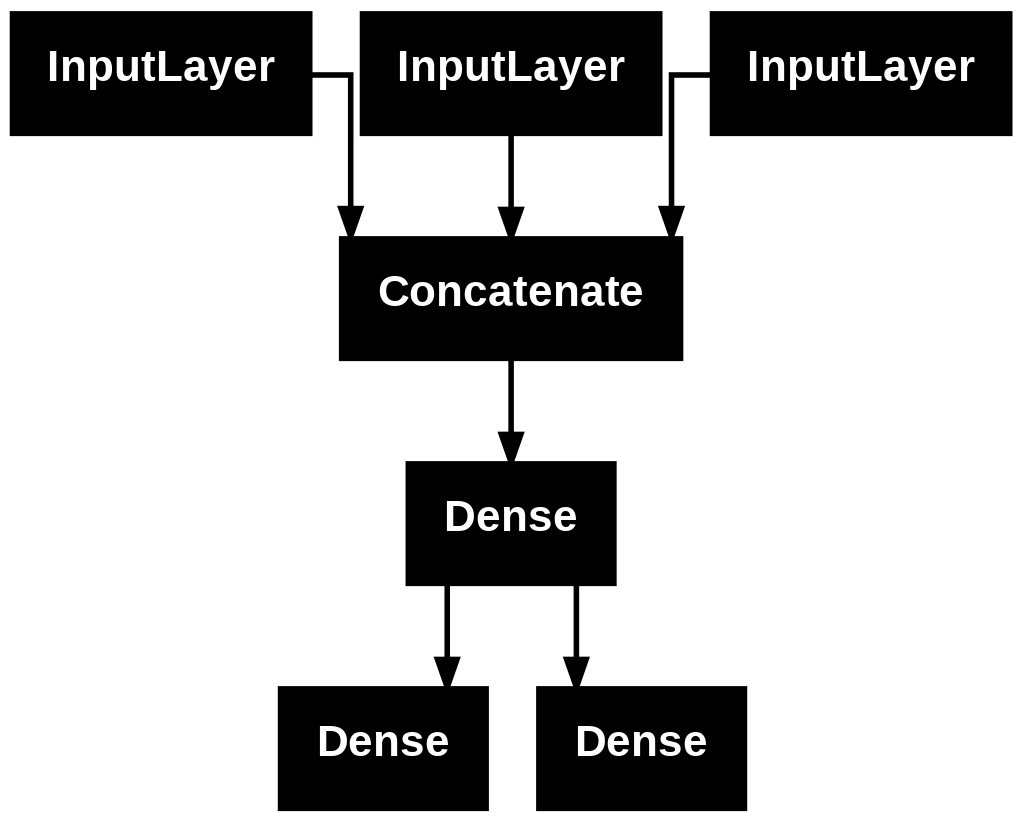

In [25]:
tf.keras.utils.plot_model(model, IMAGE_DIR / "ticket_classifier.png")

Displaying the shapes:

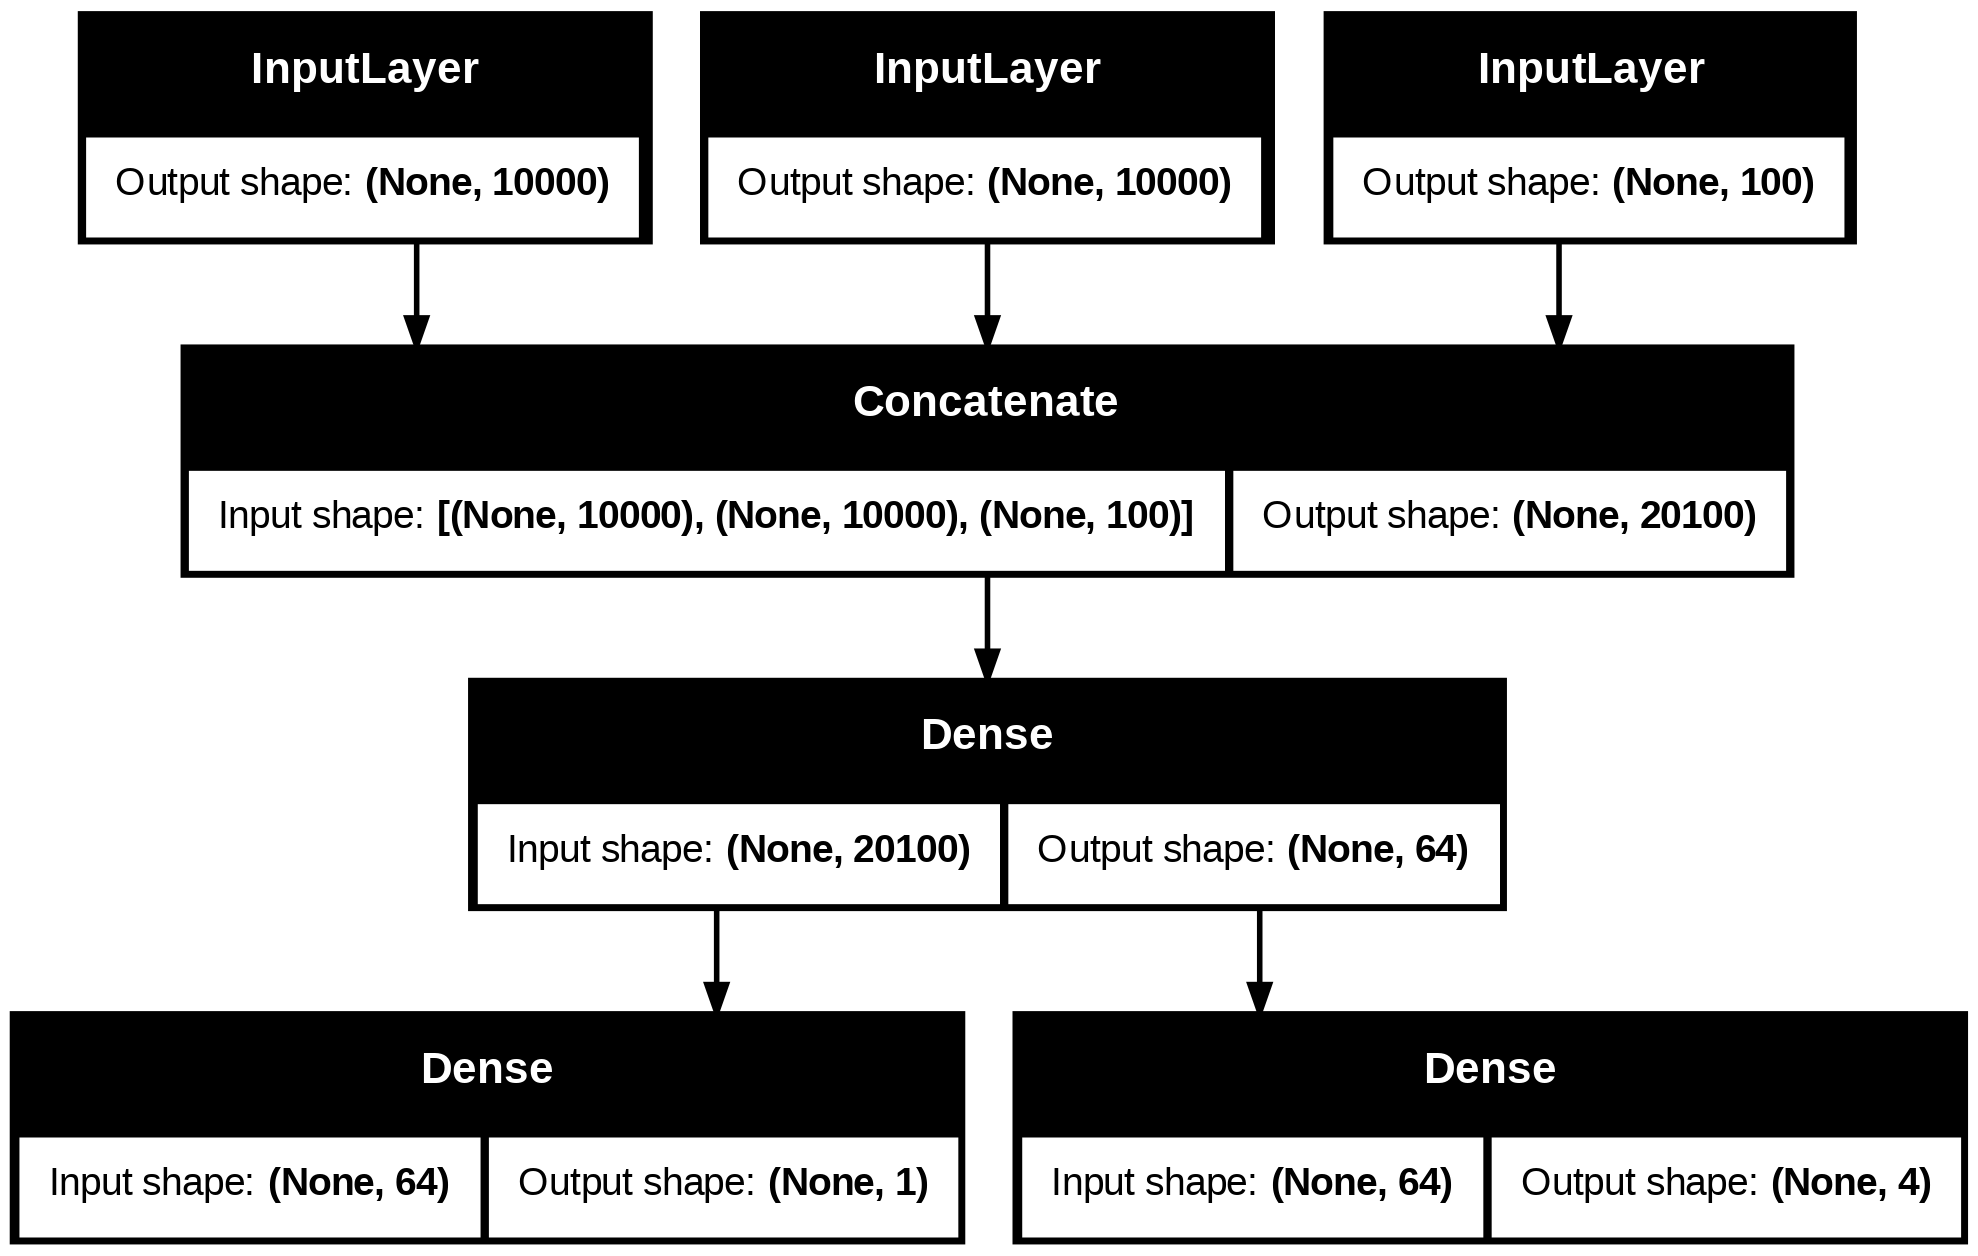

In [26]:
tf.keras.utils.plot_model(model, IMAGE_DIR / "ticket_classifier_with_shape_info.png", show_shapes=True)

#### Retrieving the inputs or outputs of a layer in a Functional model

In [27]:
model.layers # concatenate is the 4th layer, last common dense layer is 5th

[<InputLayer name=title, built=True>,
 <InputLayer name=text_body, built=True>,
 <InputLayer name=tags, built=True>,
 <Concatenate name=concatenate, built=True>,
 <Dense name=dense_10, built=True>,
 <Dense name=priority, built=True>,
 <Dense name=department, built=True>]

In [28]:
msg = "Our concatenation layer"
print(f"{msg}\n{'='*len(msg)}")
print()
msg = "inputs:"
print(f"{msg}\n{'-'*len(msg)}")
for i in model.layers[3].input:   # DISSECTING LAYER 4: inputs
    print(i)
    print()
msg = "outputs:"
print(f"{msg}\n{'-'*len(msg)}")
print(model.layers[3].output)     # DISSECTING LAYER 4: only one output

Our concatenation layer

inputs:
-------
<KerasTensor shape=(None, 10000), dtype=float32, sparse=None, name=title>

<KerasTensor shape=(None, 10000), dtype=float32, sparse=None, name=text_body>

<KerasTensor shape=(None, 100), dtype=float32, sparse=None, name=tags>

outputs:
--------
<KerasTensor shape=(None, 20100), dtype=float32, sparse=False, name=keras_tensor_14>


#### Creating a new model by reusing intermediate layer outputs

**Workflow**

1. Extract intermediate features;
2. Add a new layer / create a new output;
3. Define a new model specifying that new output.

In [29]:
                                               # 1. Extract & reuse the features of our intermediate Dense
features = model.layers[4].output              #    5th layer (after concatenate)

                                               # 2. Create a new output
difficulty = tf.keras.layers.Dense(3, activation="softmax", name="difficulty")(features)

new_model = tf.keras.Model(
    inputs=[title, text_body, tags],
    outputs=[priority, department, difficulty] # same as before, with an additional output!
)

Displaying the new topology:

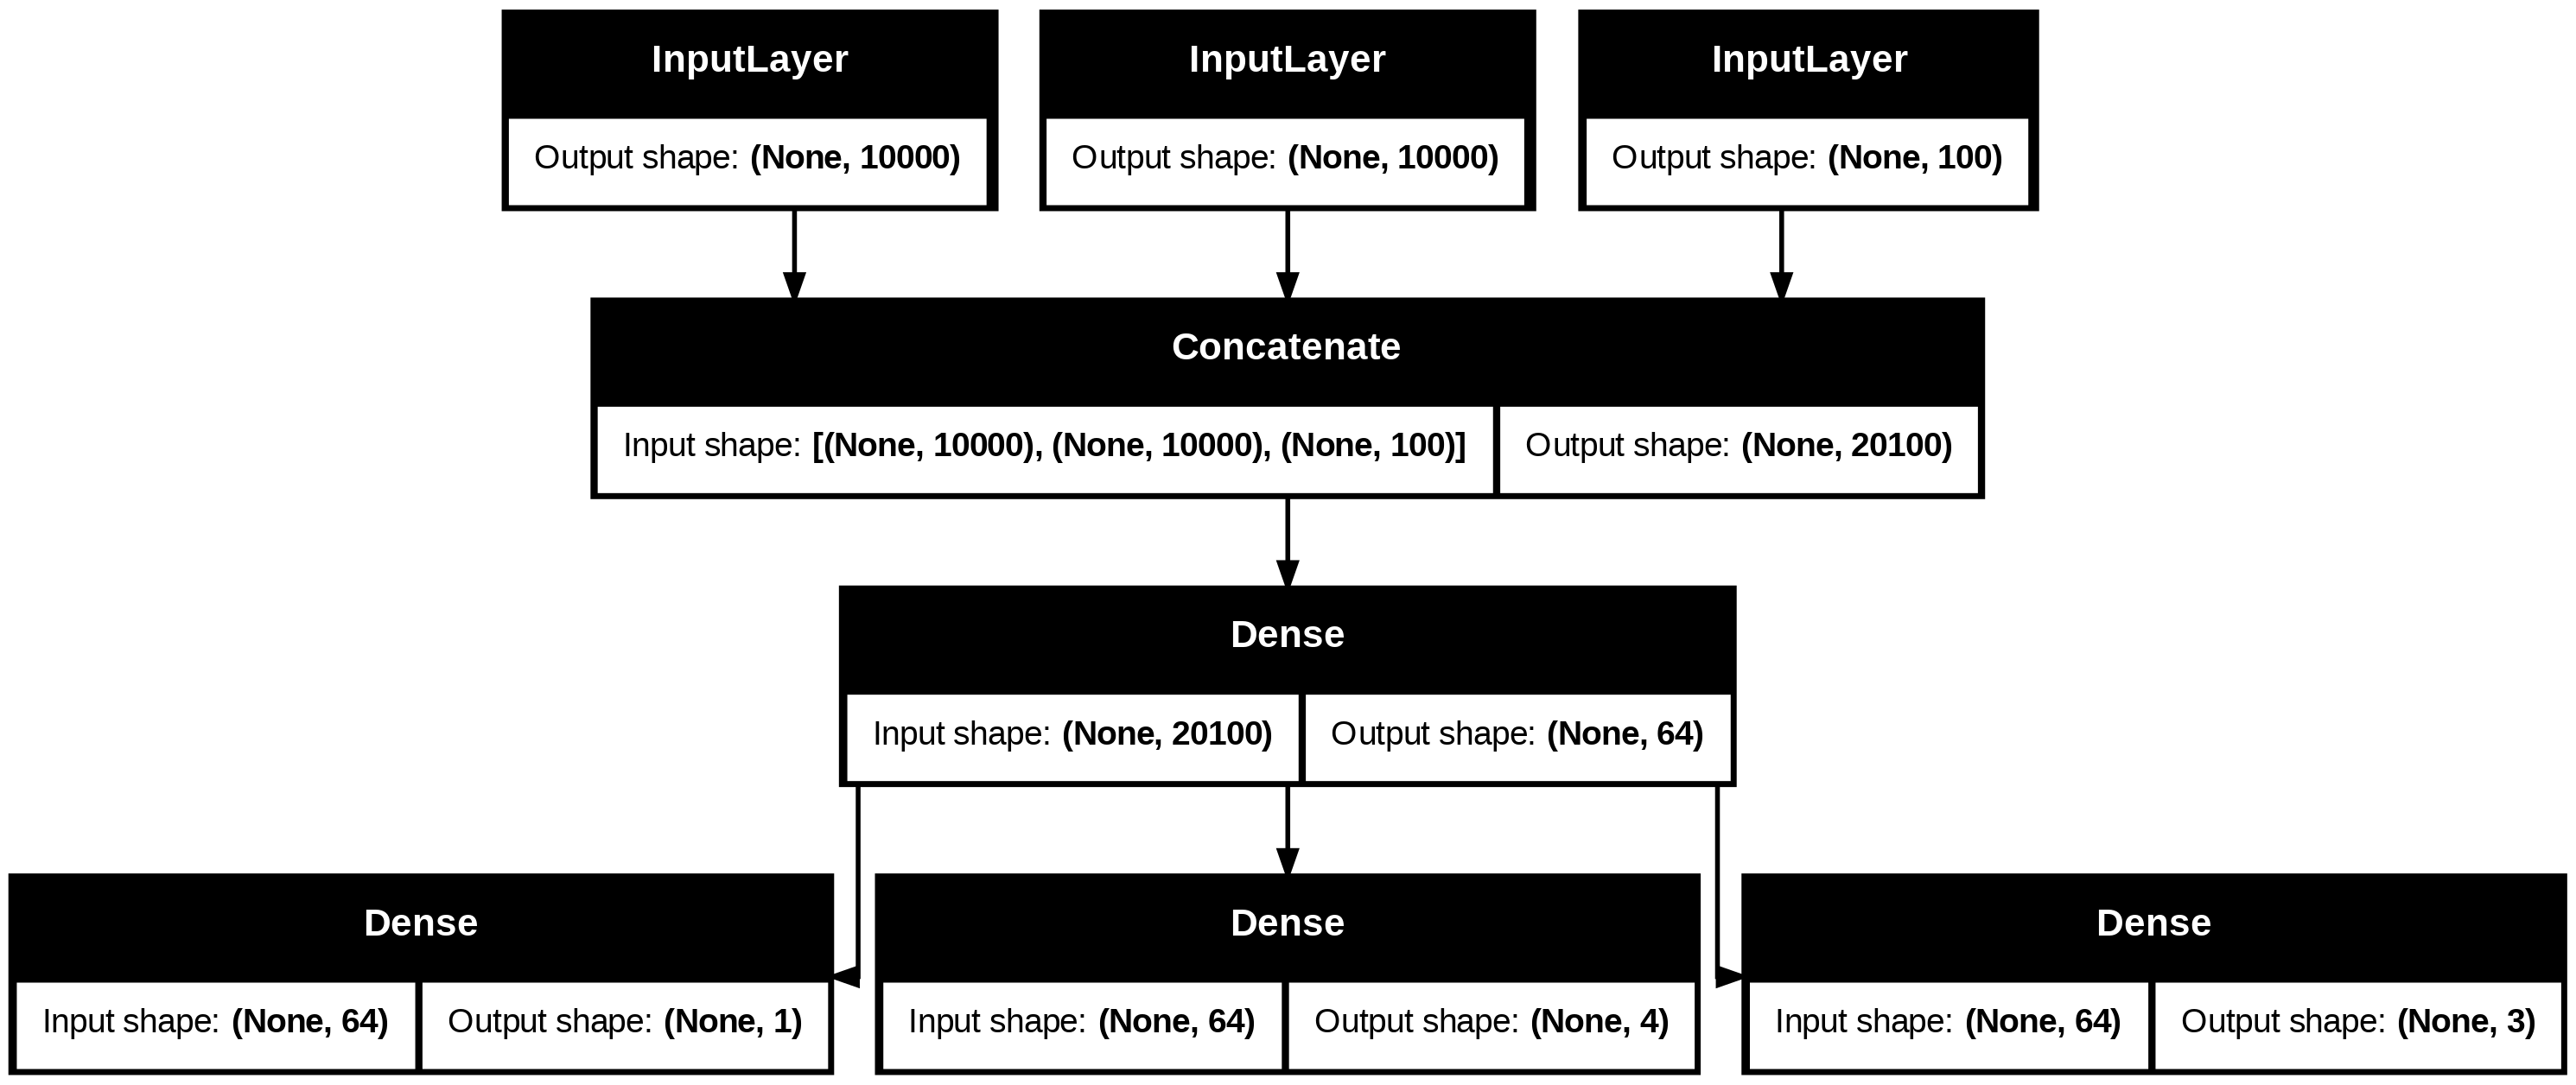

In [30]:
tf.keras.utils.plot_model(new_model, IMAGE_DIR / "updated_ticket_classifier.png", show_shapes=True)

---

### Example of layer sharing/reuse

Imagine you would like to process two different sentences for semantic similarity.  
You could use the same network to process each of them!

```python
reusable_LSTM = tf.keras.layers.LSTM(32)         # define our reusable layer

left_input = tf.keras.Input(shape=(None, 128))   # 1. first input
left_ouput = reusable_LSTM(left_input)           #    → reusable layer

right_input = tf.keras.Input(shape=(None, 128))  # 2. second input
right_output = reusable_LSTM(right_input)        #    → reusable layer
```
```python
merged = tf.keras.layers.concatenate(            # 3. concatenate
    [left_ouput, right_output], axis=-1
)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(merged)

model = tf.keras.Model([left_input, right_input], predictions)
```


#### Note: Conv filters & RNNs

Convolutional filters and RNNs are both examples of layer reuse (the same operation is applied multiple times)!

---

### Example of multiple branches: the *Inception* network

The popular *Inception* architecture has several parallel branches, doing multiple different operations on the data.

<!-- <img src="images/chollet.inception.png"> -->
<img src="https://github.com/jchwenger/AI/blob/main/7-advanced-DL-best-practices/images/chollet.inception.png?raw=true">

DLWP, 1<sup>st</sup> edition, p.236.

#### Inception pseudocode

```python
x = tf.zeros([10, 128, 128, 3])                              # ← INPUT x defined

branch_a = tf.keras.layers.Conv2D(                           # BRANCH A
    128, 1, activation="relu", strides=2, padding="same")(x) # ← x
```

```python
branch_b = tf.keras.layers.Conv2D(                           # BRANCH B
    128, 1, activation="relu", padding="same")(x)            # ← x
branch_b = tf.keras.layers.Conv2D(
    128, 3, activation="relu", strides=2, padding="same")(branch_b)
```

```python
branch_c = tf.keras.layers.AveragePooling2D(                 # BRANCH C
                # ↓ rare case of pooling with padding
    3, strides=2, padding="same")(x)                         # ← x
branch_c = tf.keras.layers.Conv2D(
    128, 3, activation="relu", padding="same")(branch_c)
```

```python
branch_d = tf.keras.layers.Conv2D(                           # BRANCH D
    128, 1, activation="relu", padding="same")(x)            # ← x
branch_d = tf.keras.layers.Conv2D(
    128, 3, activation="relu", padding="same")(branch_d)
branch_d = tf.keras.layers.Conv2D(
    128, 3, activation="relu", strides=2, padding="same")(branch_d)
```

```python
output = tf.keras.layers.concatenate(
    [branch_a, branch_b, branch_c, branch_d], axis=-1)
```

The [actual code](https://github.com/keras-team/keras-applications/blob/master/keras_applications/inception_v3.py#L169) is somewhat more extended... (*/_＼)

---

### 7.2.3 Subclassing the Model class

#### Rewriting our previous example as a subclassed model

In [33]:
class CustomerTicketModel(tf.keras.Model):                               # ← define a SUBCLASSED MODEL

    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = tf.keras.layers.Concatenate()                # the layers are now linked to
        self.mixing_layer = tf.keras.layers.Dense(64, activation="relu") # this object
        self.priority_scorer = tf.keras.layers.Dense(1, activation="sigmoid")
        self.department_classifier = tf.keras.layers.Dense(
            num_departments, activation="softmax"
        )

    def call(self, inputs):                                              # CALL: what all Keras models must implement!
        title = inputs["title"]                                          # (note: we assume 'inputs' is a dictionary)
        text_body = inputs["text_body"]
        tags = inputs["tags"]

        features = self.concat_layer([title, text_body, tags])           # where the computation actually happens
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

In [34]:
model = CustomerTicketModel(num_departments=4)                           # ← instantiate the model object

priority, department = model(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data}
)

The rest of the code is the same as before:

In [35]:
model.compile(
    optimizer="rmsprop",
    loss=["mean_squared_error", "categorical_crossentropy"],
    metrics=[["mean_absolute_error"], ["accuracy"]],
)
model.fit(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data},
    [priority_data, department_data],
    epochs=1,
)
model.evaluate(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data},
    [priority_data, department_data],
)
priority_preds, department_preds = model.predict(
    {"title": title_data, "text_body": text_body_data, "tags": tags_data}
)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2469 - loss: 91.6841 - mean_absolute_error: 0.4352
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5080 - loss: 191.7367 - mean_absolute_error: 0.5173
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


#### Beware: What subclassed models don't support

The `summary()` method will work with the **functional** syntax but not with **subclassed models**!

#### Multiple losses

Multiple losses are *summed* to get one final number.

You can modulate the importance of each element using `loss_weights`.

```python
model.compile(
    optimizer="rmsprop",
    loss=["mean_squared_error", "categorical_crossentropy"],
    # ↓ the final loss will be :
    loss_weights=[2,1]
               # ↑ (2 * `mean_squared_error` + 1 * `categorical_crossentropy`)
    metrics=[["mean_absolute_error"], ["accuracy"]],
)
```

[Keras Model documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

---

### 7.2.4 Mixing and matching different components

#### Creating a Functional model that includes a subclassed model

In [36]:
class Classifier(tf.keras.Model):                               # ← define a SUBCLASSED MODEL
    """A basic subclassed model"""
    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = "sigmoid"
        else:
            num_units = num_classes
            activation = "softmax"
        self.dense = tf.keras.layers.Dense(num_units, activation=activation)
    def call(self, inputs):                                     # CALL: what all Keras models must implement!
        return self.dense(inputs)

inputs = tf.keras.Input(shape=(3,))                             # ← FUNCTIONAL SYNTAX
features = tf.keras.layers.Dense(64, activation="relu")(inputs) # ← ..., then
outputs = Classifier(num_classes=10)(features)                  # ← our SUBCLASSED MODEL in the middle
model = tf.keras.Model(inputs=inputs, outputs=outputs)          # ← back to functional syntax


#### Creating a subclassed model that includes a Functional model

In [37]:
inputs = tf.keras.Input(shape=(64,))
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(inputs)
binary_classifier = tf.keras.Model(inputs=inputs, outputs=outputs) # ← FUNCTIONAL MODEL definition

class MyModel(tf.keras.Model):                                     # ← SUBCLASSED MODEL
    """Another basic subclassed model"""
    def __init__(self, num_classes=2):
        super().__init__()
        self.dense = tf.keras.layers.Dense(64, activation="relu")
        self.classifier = binary_classifier                        # ← included INTO OUR SUBCLASSED ONE

    def call(self, inputs):                                        # CALL: what all Keras models must implement!
        features = self.dense(inputs)
        return self.classifier(features)                           # ← used here

model = MyModel()

---

## 7.3 Using built-in training and evaluation loops

### 7.3.2 Using callbacks

You add one or more callbacks through the `callbacks` argument to `fit/evaluate/predict` in a list:

```python
model.(fit|evaluate|predict)(
    ...
    callbacks=[MyCustomCallback(), MyOtherCustomCallback()]
)
```

The [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback), [list](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) and a [tutorial](https://www.tensorflow.org/guide/keras/custom_callback).

### Early Stopping

```python
tf.keras.callbacks.EarlyStopping
```

Stops training as soon as the tracked metric stops improving. ([docs](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping))

### Checkpoints

```python
tf.keras.callbacks.ModelCheckpoint
```

Saves your network automatically. ([docs](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint))

### Learning rate schedules

While it is recommended to use `RMSprop` and `Adam` to start with (they adapt the learning rate for you)), the state of the art is usually achieved with tweaked variants of `SGD` with momentum (where you need to search for the right parameters).

In this context, you usually want your learning rate to go down as you get nearer to your optimisation goal.


```python
tf.keras.callbacks.LearningRateScheduler
tf.keras.callbacks.ReduceLROnPlateau
```

Changes your learning rate during training. ([Scheduler docs](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler))  
Reduces the learning rate during training as soon as the tracked metrick stops improving. ([Plateau docs](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau))

#### Note on Adaptive Methods

`RMSProp`, `Adam` and other adaptive methods do not need this so much as the size of the updates are already dynamically changed during the training process.

All these fancy learning rate techniques are usually implemented to make SGD outperform those! In which case you'd search for optimal performance with SGD + Momentum + Schedule + Nesterov!

### 7.3.4 Monitoring and visualization with TensorBoard

```python
tf.keras.callbacks.TensorBoard
```

Checkout [`tensorboard_in_notebooks.ipynb`](https://github.com/jchwenger/AI/blob/main/4-fundamentals/tensorboard_in_notebooks.ipynb)! Also on the VLE. ([docs](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard)) (Topic 4: Fundamentals).

More references and examples in the notebook [`callbacks.learning-rate-schedules.ipynb`](https://github.com/jchwenger/AI/blob/main/7-additional-material/07.3.2.callbacks.learning-rate-schedules.ipynb).

---

## 7.4 Writing your own training and evaluation loops

And also: **7.3.1 Writing your own metrics**

Please refer to the notebook [`custom-classes.subclassing.ipynb`](https://github.com/jchwenger/AI/blob/main/7-additional-material/custom-classes.subclassing.ipynb).

### 7.4.4 Make it fast with `@tf.function`

**Adding a `tf.function` decorator to our evaluation-step function**

```python
@tf.function # ← this decorator will compile and run the function faster
def test_step_compiled(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)

    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()

    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs
```

The same notebook [`custom-classes.subclassing.ipynb`](https://github.com/jchwenger/AI/blob/main/7-additional-material/custom-classes.subclassing.ipynb) has an example of this you can run.

---

# 13 Best practices for the real world

## 13.1 Getting the most out of your models

### 13.1.1 Hyperparameter optimization

Deep Learning engineers have many seemingly arbitrary decisions:

- How many layers?
- How many unites per layer?
- What activation function(s)?
- Batch/Layer normalise?
- How much dropout/regularisation?
- What optimizer or learning rate?
- etc..

### Hyperparameter optimisation workflow

Throughout: **Document everything**.

1. Think of a *baseline* (without a neural net & with an untrained net)
2. Choose a set of hyperparameters;
3. Build the model;
4. Fit to training data and measure performance on validation data;
5. If good enough:
    - Stop & go to 7.;
6. Go to 2;
7. Retrain with the same hyperparameters as the best run on *your entire training set* (partial train + validation, no longer any validation split!), up until the epoch where your best model started overfitting, evaluate on test data.

### Remember the three ideas!

Topic 3, [`04.1.classifying-movie-reviews-imdb.ipynb`](https://github.com/jchwenger/AI/blob/main/3-getting-started/04.1.classifying-movie-reviews-imdb.ipynb).

- **Grid search**: systematic covering of the space
- **Random search**: random trials in the space
- **Babysitting**: gradual progress with manual monitoring

---

### Keras Tuner

Keras now comes with its own module for automated hyperparameter optimisation.

If you go for the Data Science option in Coursework 2, please **do not use it**!!  
We would like you to practice building this **yourself**.

This could be used in projects with another focus.

#### References

[Documentation](https://keras.io/keras_tuner/)  
[TensorFlow tutorial](https://www.tensorflow.org/tutorials/keras/keras_tuner)

#### The future of hyperparameter tuning: automated machine learning

Automating Hyperparameter search is an active area of research, known as AutoML. Here is the [the Keras package trying to develop that](https://autokeras.com/).

---

### 13.1.2 Model ensembling

Ensembling means pooling predictions from a number of **independent models**.

The idea is based on the observation that any model can only grasp **part of the truth**.

We hope that a *more diverse* set of models might access **more aspects of the truth**.

Ensembling generally produces the most competitive models.

Pooling can proceed by **averaging** model predictions.

But there is a disadvantage – a poor model can worsen the average, even dragging it below the performace of the best model.

The predictions can be weighted, with higher weights to better models.

The weights can even be automatically optimised.  
(Idea: give the best-performing model on the validation set the highest weight...)  

#### Equal weight for all predictions

```python
preds_a = model_a.predict(x_val) # Use four different
preds_b = model_b.predict(x_val) # models to compute
preds_c = model_c.predict(x_val) # initial predictions.
preds_d = model_d.predict(x_val)
             # ↓ This new prediction array should be accurate than any of the initial ones.
final_preds = 0.25 * (preds_a + preds_b + preds_c + preds_d)
```

DLWP, p.420

#### Different weights for predictions

```python
preds_a = model_a.predict(x_val)
preds_b = model_b.predict(x_val)
preds_c = model_c.predict(x_val)
preds_d = model_d.predict(x_val)
            # ↓ These weights (0.5, 0.25, 0.1, 0.15) are assumed to be learned empirically.
final_preds = 0.5 * preds_a + 0.25 * preds_b + 0.1 * preds_c + 0.15 * preds_d
```
DLWP, p.420-1

#### Note: Diversity

The models in the ensemble need to be **as diverse** as possible.

A model in the ensemble might be comparatively poor and have low weight, but can nevertheless make a quantitative difference to the overall prediction because it was distant from the other models and may perform really well in specific situations.

The concern is for a **diversity of models** rather than how well the best model performs.

#### Note: different initialisations vs architectures

Avoid training the same model from different initialisations/order of exposure to data: this is not different enough!

Better to have different architectures or approaches (neural and not neural, for instance).

---

## 13.2 Scaling-up model training

### 13.2.1 Speeding up training on GPU with mixed precision

#### Understanding floating-point precision

There are three of levels of precision you’d typically use:
- Half precision, or `float16`, where numbers are stored on 16 bits;
- Single precision, or `float32`, where numbers are stored on 32 bits;
- Double precision, or `float64`, where numbers are stored on 64 bits.

(DLWP, p.422)

Tradeoff: for some operations, you want more **precision** (requires more compute), for others you want more **speed** (the precision matters less).

#### Manual tensor conversion

In [38]:
np_array = np.zeros((2, 2))
tf_tensor = tf.convert_to_tensor(np_array)
tf_tensor.dtype

tf.float64

In [39]:
np_array = np.zeros((2, 2))
tf_tensor = tf.convert_to_tensor(np_array, dtype="float32")
tf_tensor.dtype

tf.float32

#### Mixed-precision training in practice

```python
tf.keras.mixed_precision.set_global_policy("mixed_float16")
```

### 13.2.2 Multi-GPU training

<!-- ![Chollet mirrored strategy](images/chollet.mirrored-strategy.p.427.png) -->

![Chollet  mirrored strategy](https://github.com/jchwenger/AI/blob/main/7-advanced-DL-best-practices/images/chollet.mirrored-strategy.p.427.png?raw=true)

<small>DLWP, p.427</small>

```python
# Create a “distribution strategy” object. (go-to solution: `MirroredStrategy`)
strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")

with strategy.scope():           # Open scope: everything inside is distributed
    model = get_compiled_model() # All variables must be under the scope!
                                 # (Model construction and `compile()`)
```
```python
model.fit(                       # The training will automatically be
    train_dataset,               # distributed across devices!
    epochs=100,
    validation_data=val_dataset
)

```

#### Global batch size

When using `datasets`, the batch size is then a **global** batch size, and gets split up on each device.

Usually then you calculate it from the capacity of each GPU:

```python
batch_size = batch_size_per_device * n_devices
```

### 13.2.3 TPU training

#### Using a TPU via Google Colab

They still sometimes have a few available for free, try it with the starter code in [`lab-8-TPU`](https://github.com/jchwenger/AI/blob/main/labs/8-lab/lab-8-TPU.ipynb)! (Change the Runtime to TPU.)

This notebook also contains a link to another Colab notebook, which itself refers to **more** Colab notebooks!

#### TPU checklist

- TPUs have a lot of capacity: you can easily have larger batch sizes!
- Loading data can be a big bottleneck in these contexts. TensorFlow recommends using their [binary format TFRecords](https://www.tensorflow.org/tutorials/load_data/tfrecord) (and the [Keras page](https://keras.io/examples/keras_recipes/creating_tfrecords/));
- TPUs require that everything is compiled before it runs. You can even gain in speed by *compiling several steps of training in one* (called **step fusing**) to improve performance: specify `steps_per_execution=n` in the `compile()` method.

# Summary

### Spectrum of Workflows

- the `Sequential` syntax;
- the `Functional` syntax;
- `Model` or `Layer` subclassing
- Losses must match outputs!
- Various losses are **summed**, weighted average using `loss_weights`;
- Retrieve inner layers from models → build new ones;
- Mix & match: functional & subclassing can be combined;
- No `summary()` method with subclassing!

Personal advice: *when you reach subclassing, you may leave Keras behind and just use TF... :}*

### Advanced practices for training stability

- Residual connections;
- Batch normalisation;
- Layer normalisation.

### CNN optimisation

- Depthwise separable convolutions.

### Hyperparameter search

- DL engineering requires exploration in hyperparameter space:
    - currently guided by intuition/experience;
    - automation is coming;
    - human or automatic search should be as **systematic** as possible;
    - three ideas:
        - grid search;
        - random search;
        - babysitting

### Ensembling

- Ensembling with the appropriate weighted average of contributions is very powerful;
- Component models should be as dissimilar as possible.